I am trying to predict whether a 3D print is strong or weak in terms of tensile strength. I'll be analyzing it from the perspective of 9 variables found in the dataset: layer height, wall thickness, infill density, infill pattern, nozzle temperature, bed temperature, print speed, material used and fan speed.

Layer height refers to the amount of material laid down in one pass. Values between 0.1 mm and 0.3 mm are typical. Higher values are faster but produce a coarser finish.

Wall thickness has to do with the fact that 3D prints are generally hollow. The item's exterior as well as its interior supports have a thickness associated with them called wall thickness. There is little in the way of restrictions on this; this data set goes from 1 mm to 10 mm.

Infill density refers to how much these supports fill up the interior of the model. For an appearance piece it might be 5%, while 100% can survive high loadings but these parts are brittle.

Infill pattern are often honeycomb/hexagonal or grid/square as we have here. Theoretically any shape could be used but these are common.

The nozzle melts the raw material and then prints it onto the part. The temperature is a variable that can be used to manipulate the print. It obviously must exceed the melting temperature of the plastic and the plastic becomes more of a liquid as it increases, which can be desireable or not.

The bed supports the 3D print, and affects the cooling rate of the plastic. A warm bed means slow cooling, while a cool one means fast cooling. Typical temperatures are between 40 and 80 degrees Celsius.

Print speed indicates how quickly the material is laid down. Values vary by printer with the fastest printers putting out up to 600 mm/s.

Material in this dataset is PLA or ABS, which are the most common plastics in 3D printing.

There is a fan pointing at the nozzle and affects temperatures and solidification time. In this dataset it's measured as a percentage of maximum possible speed. Maximum speed is in the thousands of RPM.

Tensile strength is properly a material property, but 3D printed parts are harder to analyze than solid components. ABS plastic can be up to about 40 MPa while PLA can be up to around 50 MPa, with the caveat that it's more brittle so less likely to actually meet its proper strength.

Based on my experience in materials science, I predict that geometry (the first four variables) will not have an impact, while temperature (including cooling fan speed) and material will be the biggest influences. The dataset is found on Kaggle at https://www.kaggle.com/datasets/afumetto/3dprinter/data

| Statistic | Layer Height (mm) | Wall Thickness (mm) | Infill Density (%) | Nozzle Temperature (°C) | Bed Temperature (°C) | Print Speed (mm/s) | Fan Speed (%) | Tensile Strength (MPa) |
|-----------|-------------------|---------------------|--------------------|-------------------------|----------------------|--------------------|---------------|------------------------|
| Mean      | 0.11              | 5.22                | 53.4               | 221.5                   | 70                   | 64                 | 50            | 20.08                  |
| Minimum   | 0.02              | 1                   | 10                 | 200                     | 60                   | 40                 | 0             | 4                      |
| Maximum   | 0.2               | 10                  | 90                 | 250                     | 80                   | 120                | 100           | 37                   

This is a summary of my data. Tensile strength is my target variable and it will be transformed into a categorical variable. This table shows 8 of my 10 variables, the other which of two are categorical: material, which is 50% ABS and 50% PLA, and infill pattern, which is 50% rectangular (grid) and 50% hexagonal (honeycomb). Applying a classification on strength between values above and below the mean, 52% were strong while 48% were weslightly off from what would be expected splitting on the medianean). There are 50 lines in the data set with no missing values.

Tensile strength is a continuous variable in the original dataset of 3D printed items. I've reformed it into a categorical variable, split at the mean, with 1 corresponding to high strength and 0 corresponding to low strength. I chose this relatively simple classification because I did not feel I had enough data to do something more advanced. If I had more data I might classify it into high strength (mean+1SD), low strength (mean-1SD) and medium strength (everything else) with the objective being getting a truly strong 3D print, but that would end up with just a handful of points in the high and low strength choices. Infill pattern, the way the interior structure is formed, is either honeycomb (hexagonal) or grid (square) which will be encoded as 0 and 1, respectively, while material is ABS plastic or PLA plastic, which will be encoded as 0 and 1, respectively.

In [1]:
# Standard imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm

# Required for modeling and evaluation
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
#data is from a file called 3dprinter.csv
input_data = pd.read_csv('3dprinter.csv', delimiter = ',')
#tensile strength is the target variable
strength=np.array(input_data.tensile_strength)

#reclassifying strength into "low" and "high" on the mean
target_bins = [-np.inf, np.mean(strength), np.inf]
target_labels = [0,1]

#turning strength into one-hot encoding variable
strength_categorized=pd.DataFrame(pd.cut(strength, bins=target_bins, labels=target_labels))
encoder = OneHotEncoder(sparse_output=False)
strength_encoded = encoder.fit_transform(strength_categorized.values.reshape(-1, 1))

#changing infill shape and material to binary values and then one-hot encoding them
infill_shape_binary = input_data.infill_pattern.map({'honeycomb': 0, 'grid': 1})
infill_shape_encoded = encoder.fit_transform(infill_shape_binary.values.reshape(-1,1))
material_binary = input_data.material.map({'abs': 0, 'pla': 1})
material_encoded = encoder.fit_transform(material_binary.values.reshape(-1,1))

#forming a DataFrame for use in train_test_split
x=pd.DataFrame({'honeycomb': infill_shape_encoded[:,0], 'grid': infill_shape_encoded[:,1], 'abs': material_encoded[:,0], 'pla': material_encoded[:,1],
                'height': input_data.layer_height, 'thickness': input_data.wall_thickness, 'density': input_data.infill_density,
                'nozz_temp': input_data.nozzle_temperature,'bed_temp': input_data.bed_temperature, 'speed': input_data.print_speed,
                'fan': input_data.fan_speed})

#I scaled the data according to its min and max.
x_scaled=(x-x.min())/(x.max()-x.min())

#making the encoded strength into a dataframe.
strength_df=pd.DataFrame(strength_encoded,columns=["High","Low"])

#breaking into test and train with 15% testing data
X_train, X_test, Y_train, Y_test = train_test_split(x_scaled[['honeycomb','grid','abs','pla','height','thickness','density','nozz_temp',
                                                          'bed_temp','speed','fan']], strength_df[["Low","High"]], test_size=0.15, random_state=5)

And one issue with this dataset is the inability to visualize the 11-dimensional data! I will plot wall thickness and nozzle temperature for a partial visualization.

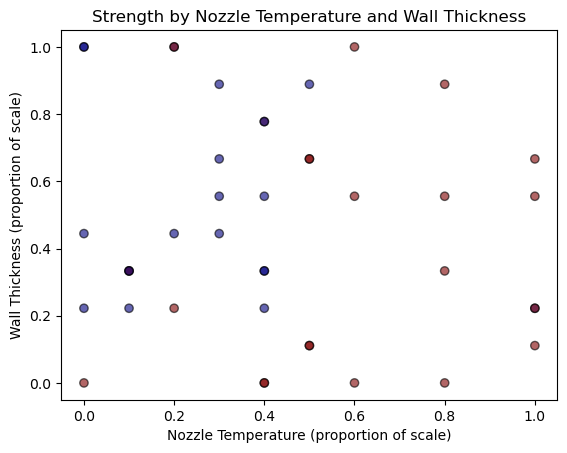

In [3]:
# Plot training set; label the axes based on the feature names
Y_train_decoded = np.argmax(Y_train, axis=1)
plt.scatter(X_train['nozz_temp'], X_train['thickness'], c=Y_train_decoded, edgecolors='k', cmap=plt.cm.jet, alpha=0.6)
plt.title('Strength by Nozzle Temperature and Wall Thickness')
plt.xlabel('Nozzle Temperature (proportion of scale)')
plt.ylabel('Wall Thickness (proportion of scale)')
plt.show()

The high strength is generally at the right, corresponding to high nozzle temperatures.

In [4]:
#I'm using linear regression for this classification problem because it is robust, simple and easily interpretable. I've classified the target variable
#into high and low strength, with the goal being to produce strong prints. It is not ideal for all classification problems, but as my target variable
#is ordinal it may be appropriate.

#using linear regression
model=LinearRegression()

#using sci-kit learn's sequential feature selector to choose variables with R-square as the target, minimum threshold of 0.01
sfs = SequentialFeatureSelector(model, 
    n_features_to_select='auto',
    direction="forward",
    scoring="r2",
    cv=5,
    tol=0.01
)

#fit the model
sfs.fit(X_train, Y_train)

# Get selected features and print them out
selected_features_mask = sfs.get_support()
selected_features_names = X_train.columns[selected_features_mask] if hasattr(X_train, 'columns') else None
print("Selected Features:", selected_features_names)

# Transform the X datasets to remove the unselected features
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

# Fit and evaluate the model on selected features
model.fit(X_train_selected, Y_train)
Y_pred = np.round(model.predict(X_test_selected))

#correlation plot to show how the choen variables are related
corr=pd.DataFrame(X_train_selected, columns=[selected_features_names]).corr()
corr.style.background_gradient(cmap='coolwarm')

Selected Features: Index(['pla', 'height', 'density', 'speed'], dtype='object')
75.0%


,"('pla',)","('height',)","('density',)","('speed',)"
pla,1.000000,0.112218,-0.228921,-0.126567
height,0.112218,1.000000,-0.056230,-0.059278
density,-0.228921,-0.056230,1.000000,-0.151192
speed,-0.126567,-0.059278,-0.151192,1.000000


This selected PLA (and dropped ABS, as expected due to collinearity), layer height, infill density and print speed.

I was expecting PLA and print speed to matter. Layer height in retrospect does make sense as the bonding between layers is an important factor for strength. It occurs to me that density may make sense as well, depending on how strength was defined. Strength divides breaking force by cross-sectional area - is this dataset using the actual area of plastic being torn, or the outside area irrespective of density? If the latter, there is no surprise that density figures into it. An accuracy of 75% seems reasonable for such a small dataset. The heatmap shows that there's not significant collinearity between the variables chosen (highest value is 0.23) and thus they are likely appropriate.

We see here that 6 out of 8 were classified correctly, matching the accuracy of 75%. 2 were predicted high strength but were actually low strength. Recall for the low prediction is 60%, while for 
it was 100%. Precision for the low prediction is 100% while for for the high prediction it's 60%. Weighted, recall is 75% and precision is 85%. The F1 score is 80%.

In [7]:
#add a constant for use of statsmodels for analysis
X_selected_with_const = sm.add_constant(X_train_selected)

# Fit the OLS model, needs binary encoding so using argmax to convert Y_train to binary
ols_model = sm.OLS(np.argmax(Y_train,axis=1), X_selected_with_const).fit()

# Print the summary to get p-values
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     11.16
Date:                Fri, 11 Jul 2025   Prob (F-statistic):           4.85e-06
Time:                        20:31:22   Log-Likelihood:                -13.668
No. Observations:                  42   AIC:                             37.34
Df Residuals:                      37   BIC:                             46.02
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1291      0.176      6.415      0.0

We see that all four variables and the F test are all under the critical alpha of 0.05, indicating statistical significance, which combined with an accuracy of 0.75, indicates this to be a good model.
The sign of the relevant values are not what I would expect. PLA breaks more easily than ABS so I do expect that value, but height, density, and speed are not what I was expecting. Because the interlayer bonding is the weak point in 3D printers, I thought taller layers would have more strength. Density should also correspond to more breaking force but it's not clear how strength was measured vis-a-vis density. I would have thought that slower printers were stronger. But this is the point of data science - finding patterns not immediately clear to human minds.

75.0%


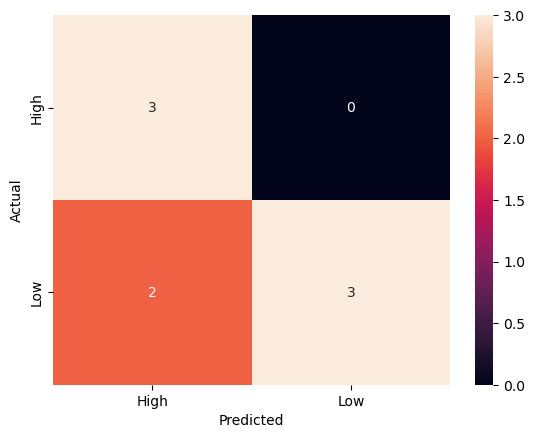

Weighted precision is: 85.0%
Weighted recall is: 75.0%
Weighted F1 score is: 79.69%


In [16]:
#calculate accuracy by seeing where Y_test and Y_pred are equal
accuracy_lin = np.mean(np.all(Y_test == Y_pred, axis=1))
print(f"{100*accuracy_lin}%")

#converting array to dataframe and decoding to binary for use in confusion matrix
Y_pred_bin=pd.DataFrame({'Low':Y_pred[:,0],'High':Y_pred[:,1]},index=Y_test.index).idxmax(axis=1)
#converting test dataframe from one-hot to binary to allow for use of confusion matrix
Y_test_bin=Y_test.idxmax(axis=1)

# Calculate confusion matrix.
confusion_matrix = pd.crosstab(Y_test_bin,Y_pred_bin, rownames=['Actual'], colnames=['Predicted'])
#Print heat map
sn.heatmap(confusion_matrix, annot=True)
plt.show()

#calculate precision for tests and predictions
precision_weighted = precision_score(Y_test, Y_pred, average='weighted')
#calculate recall for  tests and predictions
recall_weighted = recall_score(Y_test, Y_pred, average='weighted')
F1_weighted = 2/(1/precision_weighted + 1/recall_weighted)
print(f"Weighted precision is: {round(100*precision_weighted,2)}%")
print(f"Weighted recall is: {round(100*recall_weighted,2)}%")
print(f"Weighted F1 score is: {round(100*F1_weighted,2)}%")

In [17]:
#using logistic regression
model=LogisticRegression()

Y_trainLog=np.argmax(Y_train.to_numpy(),axis=1)
Y_testLog=np.argmax(Y_test.to_numpy(),axis=1)

#using sci-kit learn's sequential feature selector with R-square as the target, minimum threshold of 0.01
sfs = SequentialFeatureSelector(model, 
    n_features_to_select='auto',
    direction="forward",
    scoring="accuracy",
    cv=5,
    tol=0.01
)

#fit the model
sfs.fit(X_train, Y_trainLog)

# Get selected features
selected_features_mask = sfs.get_support()
selected_features_names = X_train.columns[selected_features_mask] if hasattr(X_train, 'columns') else None
print("Selected Features:", selected_features_names)

# Transform the datasets
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

# Fit and evaluate the model on selected features
model.fit(X_train_selected, Y_trainLog)
Y_predLog = model.predict(X_test_selected)

accuracy_log=accuracy_score(Y_testLog, Y_predLog)
print(f"{100*accuracy_log}%")

corr=pd.DataFrame(X_train_selected, columns=[selected_features_names]).corr()
corr.style.background_gradient(cmap='coolwarm')

Selected Features: Index(['abs', 'height', 'density', 'speed'], dtype='object')
87.5%


,"('abs',)","('height',)","('density',)","('speed',)"
abs,1.000000,-0.112218,0.228921,0.126567
height,-0.112218,1.000000,-0.056230,-0.059278
density,0.228921,-0.056230,1.000000,-0.151192
speed,0.126567,-0.059278,-0.151192,1.000000


Accuracy is a little better (87.5% instead of 75%) with logistic regression, as expected for a classification task. Two things still count against it: it's marginally less interpretable, and when I used unnormalized data it failed to produce good results, with 38% accuracy, while linear regression didn't seem to care. These are both minor issues.

In [18]:
#add a constant for use of statsmodels for anlaysis
X_selected_with_const = sm.add_constant(X_train_selected)

# Fit the OLS model, needs binary encoding so using argmax to convert Y_train to binary
logits_model = sm.Logit(Y_trainLog, X_selected_with_const).fit()

# Print the summary to get p-values
print(logits_model.summary())

Optimization terminated successfully.
         Current function value: 0.300723
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   42
Model:                          Logit   Df Residuals:                       37
Method:                           MLE   Df Model:                            4
Date:                Fri, 11 Jul 2025   Pseudo R-squ.:                  0.5633
Time:                        20:46:48   Log-Likelihood:                -12.630
converged:                       True   LL-Null:                       -28.921
Covariance Type:            nonrobust   LLR p-value:                 1.454e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6060      1.423      1.128      0.259      -1.184       4.396
x1             4.8436      1.

The regression analytics aren't ideal, with the constant and x2 (layer height) both showing p-values in excess of 0.05, but layer height wasn't much higher so I might still include it in the model.

In [23]:
#calculate precision for tests and predictions
precision_weighted_log = precision_score(Y_testLog, Y_predLog, average='weighted')
#calculate recall for  tests and predictions
recall_weighted_log = recall_score(Y_testLog, Y_predLog, average='weighted')
F1_weighted_log = 2/(1/precision_weighted_log + 1/recall_weighted_log)
print(f"Weighted precision is: {round(100*precision_weighted_log,2)}%")
print(f"Weighted recall is: {round(100*recall_weighted_log,2)}%")
print(f"Weighted F1 score is: {round(100*F1_weighted_log,2)}%")

[0 1 1 0 0 0 1 0]
[1 1 1 0 0 0 1 0]
Weighted precision is: 90.62%
Weighted recall is: 87.5%
Weighted F1 score is: 89.04%


Precision for the logistic model is 91%, and recall is 88%, F1 score is 89%, and accuracy is 87.5%, all better than for linear regression.
Overall, logistic regression has better evaluation features than linear regression, as expected for a classification problem. While this was a fun experiment in linear regression, logistic regression will be my go-to in the future for classification - and I'll make a point of normalizing my values.

Overall I'm pleased with how this turned out. I've worked as a 3D printing engineer before and data was rarer back then so there was a lot of guesswork, so it was nice to actually look at it from a mathematical perspective. But before I draw any real conclusions from this, I must repeat the cry of the machine learning engineer: more data!